<a href="https://colab.research.google.com/github/hyunku/Reservoir-Computing/blob/main/ESN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/cknd/pyESN 참고

In [ ]:
import numpy as np


def correct_dimensions(s, targetlength):
    """checks the dimensionality of some numeric argument s, broadcasts it
       to the specified length if possible.
    Args:
        s: None, scalar or 1D array
        targetlength: expected length of s
    Returns:
        None if s is None, else numpy vector of length targetlength
    """
    if s is not None:
        s = np.array(s)
        if s.ndim == 0:
            s = np.array([s] * targetlength)
        elif s.ndim == 1:
            if not len(s) == targetlength:
                raise ValueError("arg must have length " + str(targetlength))
        else:
            raise ValueError("Invalid argument")
    return s


def identity(x):
    return x


class ESN():

    def __init__(self, n_inputs, n_outputs, n_reservoir=200,
                 spectral_radius=0.95, sparsity=0, noise=0.001, input_shift=None,
                 input_scaling=None, teacher_forcing=True, feedback_scaling=None,
                 teacher_scaling=None, teacher_shift=None,
                 out_activation=identity, inverse_out_activation=identity,
                 random_state=None, silent=True):
        """
        Args:
            n_inputs: number of input dimensions -> 인풋 뉴런 숫자
            n_outputs: number of output dimensions -> 출력층 뉴런 숫자
            n_reservoir: number of reservoir neurons -> reservoir 뉴런 수
            spectral_radius: spectral radius of the recurrent weight matrix -> reservoir 업데이트 가중치 행렬 학습률
            sparsity: proportion of recurrent weights set to zero -> reservoir 뉴런들 연결 끊을 확률 -> 랜덤하게 특정 비율 reservoir 업데이트 가중치 행렬 0으로 만듬 
            noise: noise added to each neuron (regularization) -> 규제 계수
            input_shift: scalar or vector of length n_inputs to add to each
                        input dimension before feeding it to the network. -> 인풋 값을 reservoir 에 주입하기 전에 더해줄 수치. -> 인풋 차원이 2차원 이상이면 [2,5] 이런식으로 리스트에 담아주기
            input_scaling: scalar or vector of length n_inputs to multiply
                        with each input dimension before feeding it to the netw. -> 인풋 값을 reservoir 에 주입하기 전에 곱해줄 수치.-> 인풋 차원이 2차원 이상이면 [2,5] 이런식으로 리스트에 담아주기
            teacher_forcing: if True, feed the target back into output units -> 타겟값을 reservoir로 보낼 것인지 여부
            teacher_scaling: factor applied to the target signal -> 타겟 값에 적용되는 계수(곱) -> Herbert Jaeger's original Matlab code 에 따르면 1.12
            teacher_shift: additive term applied to the target signal -> 타겟 값에 더해줄 계수(합) -> Herbert Jaeger's original Matlab code 에 따르면 -0.7
            out_activation: output activation function (applied to the readout) -> 출력층 뉴런에 곱해줄 활성함수 (np.tanh)
            inverse_out_activation: inverse of the output activation function -> np.arctanh
            random_state: positive integer seed, np.rand.RandomState object,
                          or None to use numpy's builting RandomState.
            silent: supress messages -> 학습도중 출력되는 메세지 온오프 여부
        """
        # check for proper dimensionality of all arguments and write them down.
        self.n_inputs = n_inputs # 인풋 뉴런 수
        self.n_reservoir = n_reservoir # reservoir 뉴런 수
        self.n_outputs = n_outputs # 출력층 뉴런 수
        self.spectral_radius = spectral_radius # reservoir 업데이트 가중치 행렬 학습률
        self.sparsity = sparsity # reservoir 뉴런들 연결 끊을 확률 -> 랜덤하게 특정 비율 reservoir 업데이트 가중치 행렬 0으로 만듬 
        self.noise = noise # 규제 계수
        self.input_shift = correct_dimensions(input_shift, n_inputs) # 인풋 값을 reservoir 에 주입하기 전에 더해줄 수치. -> 인풋 차원이 2차원 이상이면 [2,5] 이런식으로 리스트에 담아주기
        self.input_scaling = correct_dimensions(input_scaling, n_inputs) # 인풋 값을 reservoir 에 주입하기 전에 곱해줄 수치.-> 인풋 차원이 2차원 이상이면 [2,5] 이런식으로 리스트에 담아주기

        self.teacher_scaling = teacher_scaling # 타겟 값에 적용되는 계수(곱) -> Herbert Jaeger's original Matlab code 에 따르면 1.12
        self.teacher_shift = teacher_shift # 타겟 값에 더해줄 계수(합) -> Herbert Jaeger's original Matlab code 에 따르면 -0.7

        self.out_activation = out_activation # 출력층 뉴런에 곱해줄 활성함수 (np.tanh)
        self.inverse_out_activation = inverse_out_activation # np.arctanh
        self.random_state = random_state

        # the given random_state might be either an actual RandomState object,
        # a seed or None (in which case we use numpy's builtin RandomState)
        if isinstance(random_state, np.random.RandomState):
            self.random_state_ = random_state
        elif random_state:
            try:
                self.random_state_ = np.random.RandomState(random_state)
            except TypeError as e:
                raise Exception("Invalid seed: " + str(e))
        else:
            self.random_state_ = np.random.mtrand._rand

        self.teacher_forcing = teacher_forcing # 타겟값을 reservoir로 보낼 것인지 여부
        self.silent = silent # 학습도중 출력되는 메세지 온오프 여부
        self.initweights() # 맨 처음 실행하면(__init__에 의해 실행됨) 랜덤 가중치 행렬 생성

    def initweights(self): # 초기 가중치 행렬 생성
        # initialize recurrent weights:
        # begin with a random matrix centered around zero:
        W = self.random_state_.rand(self.n_reservoir, self.n_reservoir) - 0.5 # W 차원 : (res,res)
        # delete the fraction of connections given by (self.sparsity):
        W[self.random_state_.rand(*W.shape) < self.sparsity] = 0 # 연결안될 확률 -> 가중치 매트릭스에서 랜덤 비율만큼 0으로 설정
        # compute the spectral radius of these weights:
        radius = np.max(np.abs(np.linalg.eigvals(W))) # spectral radius 추출
        # rescale them to reach the requested spectral radius:
        self.W = W * (self.spectral_radius / radius) # spectral radius 사용량(가중치 학습률)

        # random input weights: # W_in(입력층 가중치) 차원 : (res, 인풋노드 수)
        self.W_in = self.random_state_.rand(
            self.n_reservoir, self.n_inputs) * 2 - 1
        # random feedback (teacher forcing) weights: # W_feedb(출력층 가중치) 차원 : (res, 출력층노드 수)
        self.W_feedb = self.random_state_.rand(
            self.n_reservoir, self.n_outputs) * 2 - 1

    def _update(self, state, input_pattern, output_pattern): # reservoir 내부 뉴런 학습치 -> (1(이전데이터),res), (1(현재데이터),입력층 뉴런수), (1(이전데이터),출력층 뉴런수)
        """performs one update step.
        i.e., computes the next network state by applying the recurrent weights
        to the last state & and feeding in the current input and output patterns
        """
        if self.teacher_forcing: # 타겟 데이터 주입 -> 이전시점 reservoir뉴런 학습치 + 인풋에서 주입하는 값 + 타겟에서 주입하는 값 
            # 행렬과 스칼라 dot 때리면 matmul로 변함
            # preactivation 차원 : (1,res)
            preactivation = (np.dot(self.W, state) # (res,res) matmul (1,res) -> (1,res) -> (res,) : 이전시점 reservoir 노드와 해당하는 가중치 행렬 내적
                             + np.dot(self.W_in, input_pattern) # (res, 입력층 뉴런수) matmul (1, 입력층 뉴런수) -> (1,res) -> (res,) # 현재 시점 데이터와 입력층 가중치 내적
                             + np.dot(self.W_feedb, output_pattern)) # (res, 출력층 뉴런수) matmul (1, 출력층 뉴런수) -> (1,res) -> (res,) # 이전 시점 데이터와 출력층 가중치 내적
        else: # 타겟 데이터 주입 X
            preactivation = (np.dot(self.W, state) # (res,res) matmul (1,res) -> (1,res) -> (res,) 
                             + np.dot(self.W_in, input_pattern)) # (res, 입력층 뉴런수) matmul (1, 입력층 뉴런수) -> (1,res) -> (res,)
        return (np.tanh(preactivation) # 다음 reservoir 뉴런 학습치는 이전 단계의 reservoir 학습치와 현시점 인풋 데이터와 현시점 타겟 데이터의 합에 활성함수를 씌워준 것. + 규제항 적용
                + self.noise * (self.random_state_.rand(self.n_reservoir) - 0.5))

    def _scale_inputs(self, inputs):
        """for each input dimension j: multiplies by the j'th entry in the
        input_scaling argument, then adds the j'th entry of the input_shift
        argument."""
        if self.input_scaling is not None:
            inputs = np.dot(inputs, np.diag(self.input_scaling))
        if self.input_shift is not None:
            inputs = inputs + self.input_shift
        return inputs

    def _scale_teacher(self, teacher):
        """multiplies the teacher/target signal by the teacher_scaling argument,
        then adds the teacher_shift argument to it."""
        if self.teacher_scaling is not None:
            teacher = teacher * self.teacher_scaling
        if self.teacher_shift is not None:
            teacher = teacher + self.teacher_shift
        return teacher

    def _unscale_teacher(self, teacher_scaled):
        """inverse operation of the _scale_teacher method."""
        if self.teacher_shift is not None:
            teacher_scaled = teacher_scaled - self.teacher_shift
        if self.teacher_scaling is not None:
            teacher_scaled = teacher_scaled / self.teacher_scaling
        return teacher_scaled

    def fit(self, inputs, outputs, inspect=False):
        """
        Collect the network's reaction to training data, train readout weights.
        Args:
            inputs: array of dimensions (N_training_samples x n_inputs)
            outputs: array of dimension (N_training_samples x n_outputs)
            inspect: show a visualisation of the collected reservoir states
        Returns:
            the network's output on the training data, using the trained weights
        """
        # 인풋, 타겟 데이터 가공 과정
        # transform any vectors of shape (x,) into vectors of shape (x,1):
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        if outputs.ndim < 2:
            outputs = np.reshape(outputs, (len(outputs), -1))
        # transform input and teacher signal:
        inputs_scaled = self._scale_inputs(inputs) # (학습 데이터 수, 인풋 뉴런 수)
        teachers_scaled = self._scale_teacher(outputs) # (학습 데이터 수, 출력 뉴런 수)

        if not self.silent:
            print("harvesting states...")

        # 학습 과정
        # step the reservoir through the given input,output pairs:
        states = np.zeros((inputs.shape[0], self.n_reservoir)) # 학습 과정 중 학습될 reservoir뉴런의 학습치 행렬, 우선 초기값 설정(학습 데이터 수, res)
        for n in range(1, inputs.shape[0]): # 학습 데이터 전체 돌면서
            states[n, :] = self._update(states[n - 1], inputs_scaled[n, :], # update((1(이전데이터),res), (1(현재데이터),입력층 뉴런수), (1(이전데이터),출력층 뉴런수))
                                        teachers_scaled[n - 1, :]) # reservoir뉴런 학습치 행렬에 학습 횟수마다 업데이트한 값으로 수정

        # learn the weights, i.e. find the linear combination of collected
        # network states that is closest to the target output
        if not self.silent:
            print("fitting...")
        # we'll disregard the first few states: # reservoir가 recurrent한 구조를 띄고 있으므로, 초기 몇개의 reservoir는 없앰
        transient = min(int(inputs.shape[1] / 10), 100) # 10의 배수마다 삭제하는 뉴런 1개씩 증가. 단, 삭제 뉴런은 최대치 100개
        # vstack : 위아래 결합, hstack : 좌우 결합
        # include the raw inputs: -> 인풋뉴런에서 reservoir 뉴런 또한 이어지므로, target 예측 시에는 인풋 뉴런 또한 reservoir 뉴런들과 합쳐줘야함.
        extended_states = np.hstack((states, inputs_scaled)) # (학습 데이터 수, res + 입력층 뉴런 수)
        # Solve for W_out:
        # Ax = y (A는 extended_states, 추론에 사용할 행렬, y는 target data의 groud truth) 에서 x 값(최소제곱해) 을 구해야함
        # 정규방정식에 의해, A.T * A * x = A.T * y 
        # x = inverse(A.T * A) * A.T * y 에서 A가 full column rank(column들끼리 종속성이 하나도 없을 때) 라고 가정할 때,
        # x = A.TT * y 가 성립 (A.TT는 A의 유사역행렬) 하고, 최소제곱해는 단 1개가 나올 것임. 단, full column rank가 아닐 경우, 해는 무수히 많이 생길 것. 
        # time series data 이므로, full row rank는 아닐 확률 높음. 하지만 알바 아님. (전 시간축의 데이터에 영향을 받음)
        # full column rank를 지키려면, 인풋 속성이 서로 종속이면 안됌. reservoir 뉴런들끼리는 각각 다르게 학습 진행하였으므로, 독립이 자명.
        # 즉, 가역행렬이 아니라도, full column rank를 지키고 있어서, 유사역행렬로 대체하여 최소제곱해를 구할 수 있음.
        # np.linalg.pinv(extended_states[transient:, :]) : 유사역행렬, A.TT 로 인식 -> 차원 : (res + 입력층 뉴런 수, 학습 데이터 수)
        # self.inverse_out_activation(teachers_scaled[transient:, :]) : y로 인식. 단, 활성함수를 통하여 최종 출력 값이 나오므로, 실제값에 역활성함수를 적용시킨 값을 y로 사용해야 함.
        # (res + 입력층 뉴런 수, 학습 데이터 수) dot 내적 (학습 데이터 수, 출력층 뉴런 수) -> (res + 입력층 뉴런 수, 출력층 뉴런 수)
        # W_out 차원 : (출력층 뉴런수, res+입력층 뉴런 수) (T로 전치해주었음)
        self.W_out = np.dot(np.linalg.pinv(extended_states[transient:, :]),
                            self.inverse_out_activation(teachers_scaled[transient:, :])).T  # x = A.TT * y 로 가중치 매트릭스를 구함.

        # remember the last state for later:
        self.laststate = states[-1, :] # reservoir의 마지막 뉴런
        self.lastinput = inputs[-1, :] # (1(입력 데이터 마지막 row), 입력층 뉴런 수)
        self.lastoutput = teachers_scaled[-1, :] # (1(타겟 데이터 마지막 row), 출력층 뉴런 수)

        # optionally visualize the collected states
        if inspect:
            from matplotlib import pyplot as plt
            # (^-- we depend on matplotlib only if this option is used)
            plt.figure(
                figsize=(states.shape[0] * 0.0025, states.shape[1] * 0.01))
            plt.imshow(extended_states.T, aspect='auto',
                       interpolation='nearest')
            plt.colorbar()

        if not self.silent:
            print("training error:")
        # apply learned weights to the collected states: # 타겟 데이터를 스케일링 했으면, 스케일링 해제, 아니면 그대로
        pred_train = self._unscale_teacher(self.out_activation(
            np.dot(extended_states, self.W_out.T))) # (학습 데이터 수, res + 입력층 뉴런 수) dot (res + 입력층 뉴런 수, 출력층 뉴런 수) -> (학습 데이터 수, 출력층 뉴런 수)
        if not self.silent:
            print(np.sqrt(np.mean((pred_train - outputs)**2)))
        return pred_train

    def predict(self, inputs, continuation=True):
        """
        Apply the learned weights to the network's reactions to new input.
        Args:
            inputs: array of dimensions (N_test_samples x n_inputs)
            continuation: if True, start the network from the last training state
        Returns:
            Array of output activations
        """
        if inputs.ndim < 2:
            inputs = np.reshape(inputs, (len(inputs), -1))
        n_samples = inputs.shape[0]

        if continuation: # 학습한 가중치 사용
            laststate = self.laststate
            lastinput = self.lastinput
            lastoutput = self.lastoutput
        else: # 학습한 가중치 사용 X
            laststate = np.zeros(self.n_reservoir)
            lastinput = np.zeros(self.n_inputs)
            lastoutput = np.zeros(self.n_outputs)

        inputs = np.vstack([lastinput, self._scale_inputs(inputs)]) # recurrent 한 구조를 띄고 있으므로 인풋으로 학습과정 마지막 데이터 1개가 필요함.
        states = np.vstack(
            [laststate, np.zeros((n_samples, self.n_reservoir))]) # 학습과정 마지막 reservoir 뉴런 학습치에 이어서 사용
        outputs = np.vstack(
            [lastoutput, np.zeros((n_samples, self.n_outputs))]) # 타겟 값으로 train셋의 마지막 타겟 값 1개 필요

        for n in range(n_samples): # 예측할 새로운 데이터셋 전체를 돌면서
            states[
                n + 1, :] = self._update(states[n, :], inputs[n + 1, :], outputs[n, :]) # 새로운 데이터에 맞게 reservoir뉴런 학습
            outputs[n + 1, :] = self.out_activation(np.dot(self.W_out, # 새로운 데이터와 새로 학습한 reservoir뉴런 학습치를 이용하여 미래 예측
                                                           np.concatenate([states[n + 1, :], inputs[n + 1, :]])))

        return self._unscale_teacher(self.out_activation(outputs[1:]))

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


test error: 
0.13960391060505584


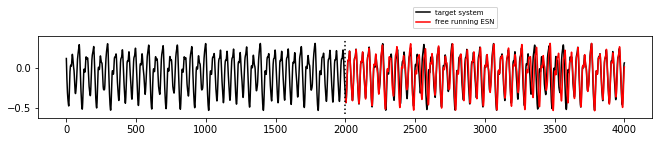

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

data = np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/MackeyGlass_t17.txt')
esn = ESN(n_inputs = 1,
          n_outputs = 1,
          n_reservoir = 500,
          spectral_radius = 1.5,
          random_state=42)

trainlen = 2000
future = 2000
pred_training = esn.fit(np.ones(trainlen),data[:trainlen])

prediction = esn.predict(np.ones(future))
print("test error: \n"+str(np.sqrt(np.mean((prediction.flatten() - data[trainlen:trainlen+future])**2))))

plt.figure(figsize=(11,1.5))
plt.plot(range(0,trainlen+future),data[0:trainlen+future],'k',label="target system")
plt.plot(range(trainlen,trainlen+future),prediction,'r', label="free running ESN")
lo,hi = plt.ylim()
plt.plot([trainlen,trainlen],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
plt.legend(loc=(0.61,1.1),fontsize='x-small')